**Moooooooodel**

## Environment Setup & Libraries
This line suppresses unnecessary TensorFlow warning messages to keep the output clean.
It does not affect the model training or performance.

In [9]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

TensorFlow and Keras are used to build and train the CNN model.

NumPy is used for numerical operations.

Matplotlib and Seaborn are used for visualization (e.g., confusion matrix).

# Evaluation Libraries
These metrics are used to evaluate the trained model:

- Accuracy: overall correctness.

- Classification report: precision, recall, and F1-score for each class.

- Confusion matrix: visualizes correct and incorrect predictions.

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print(tf.__version__)
print(tf.config.list_physical_devices("GPU"))

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score
)

2.19.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Dataset Paths

The dataset is split into:

Training set: used to train the model.

Validation set: used to monitor performance and prevent overfitting.

Test set: used for final evaluation on unseen data.

## Image Configuration
Images are resized to 224×224, which is the input size expected by MobileNetV2.

Batch size defines how many images are processed together in one step.

In [ ]:
TRAIN_DIR = "/content/drive/MyDrive/AI_Project/split/split/train"
VAL_DIR   = "/content/drive/MyDrive/AI_Project/split/split/val"
TEST_DIR  = "/content/drive/MyDrive/AI_Project/split/split/test"

IMG_SIZE = (224,224)
BATCH_SIZE = 32

In [12]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=42
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=42
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=42
)

class_names = train_ds.class_names
NUM_CLASSES = len(class_names)
print(NUM_CLASSES)

Found 4186 files belonging to 31 classes.
Found 585 files belonging to 31 classes.
Found 1212 files belonging to 31 classes.
31


In [13]:
print(train_ds.class_names)
print(len(train_ds.class_names))

['n000001', 'n000004', 'n000006', 'n000008', 'n000009', 'n000010', 'n000026', 'n000028', 'n000029', 'n000030', 'n000037', 'n000038', 'n000040', 'n000043', 'n000047', 'n000052', 'n000054', 'n000056', 'n000065', 'n000067', 'n000069', 'n000071', 'n000077', 'n000079', 'n000082', 'n000083', 'n000090', 'n000091', 'n000092', 'n000093', 'ziad abdullah-20251221T200616Z-1-001']
31


## Performance Optimization (tf.data)
cache() stores the dataset in memory after the first load.

prefetch() overlaps data loading with model execution.

This significantly improves training speed and efficiency.

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)
test_ds  = test_ds.cache().prefetch(AUTOTUNE)

## Transfer Learning: Base Model
MobileNetV2 is loaded with pre-trained weights from ImageNet.

include_top=False removes the original classifier layers.

The model is used as a feature extractor.

- The base model layers are frozen to preserve the learned general features (edges, textures, shapes) and prevent overfitting on a small dataset.

In [8]:
base_model = tf.keras.applications.MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=IMG_SIZE + (3,)
)

base_model.trainable = False

inputs = layers.Input(shape=IMG_SIZE + (3,))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
x = base_model(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation="relu")(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = models.Model(inputs, outputs)
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 31)             │         3,999 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,425,951 (9.25 MB)

 Trainable params: 167,967 (656.12 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Training Configuration
An epoch represents one full pass over the entire training dataset.
The model is trained for 18 epochs to allow it to gradually improve its performance.

best_val_acc is used to track the highest validation accuracy achieved during training.
This helps in saving the best-performing model instead of the last one.

In [15]:
EPOCHS = 18
best_val_acc = 0.0

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(1e-4)
for epoch in range(EPOCHS):

    # -------- TRAIN --------
    train_correct = 0
    train_total = 0
    train_loss = 0.0

    for images, labels in train_ds:
        with tf.GradientTape() as tape:
            outputs = model(images, training=True)
            loss = loss_fn(labels, outputs)

        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        preds = tf.argmax(outputs, axis=1, output_type=tf.int32)
        train_correct += tf.reduce_sum(tf.cast(preds == labels, tf.int32))
        train_total += labels.shape[0]
        train_loss += loss.numpy() * labels.shape[0]

    train_acc = train_correct / train_total
    train_loss /= train_total

    # -------- VALIDATION --------
    val_correct = 0
    val_total = 0
    val_loss = 0.0

    for images, labels in val_ds:
        outputs = model(images, training=False)
        loss = loss_fn(labels, outputs)

        preds = tf.argmax(outputs, axis=1, output_type=tf.int32)
        val_correct += tf.reduce_sum(tf.cast(preds == labels, tf.int32))
        val_total += labels.shape[0]
        val_loss += loss.numpy() * labels.shape[0]

    val_acc = val_correct / val_total
    val_loss /= val_total

    print(
        f"Epoch [{epoch+1}/{EPOCHS}] "
        f"Train Acc: {train_acc:.4f} | "
        f"Val Acc: {val_acc:.4f}"
    )

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        model.save("mobilenet_best.h5")


Epoch [1/18] Train Acc: 0.1020 | Val Acc: 0.1504


Epoch [2/18] Train Acc: 0.2320 | Val Acc: 0.2513


Epoch [3/18] Train Acc: 0.3502 | Val Acc: 0.3487


Epoch [4/18] Train Acc: 0.4300 | Val Acc: 0.4171


Epoch [5/18] Train Acc: 0.5022 | Val Acc: 0.4752


Epoch [6/18] Train Acc: 0.5592 | Val Acc: 0.5145


Epoch [7/18] Train Acc: 0.6008 | Val Acc: 0.5248


Epoch [8/18] Train Acc: 0.6345 | Val Acc: 0.5504


Epoch [9/18] Train Acc: 0.6663 | Val Acc: 0.5675


Epoch [10/18] Train Acc: 0.6911 | Val Acc: 0.5726


Epoch [11/18] Train Acc: 0.7117 | Val Acc: 0.5880


Epoch [12/18] Train Acc: 0.7284 | Val Acc: 0.6000


Epoch [13/18] Train Acc: 0.7434 | Val Acc: 0.6017


Epoch [14/18] Train Acc: 0.7575 | Val Acc: 0.6137


Epoch [15/18] Train Acc: 0.7731 | Val Acc: 0.6188
Epoch [16/18] Train Acc: 0.7867 | Val Acc: 0.6188
Epoch [17/18] Train Acc: 0.8022 | Val Acc: 0.6188
Epoch [18/18] Train Acc: 0.8122 | Val Acc: 0.6188


## Initializing Training Metrics
These variables are used to calculate:

- Training accuracy

- Average training loss per epoch

In [16]:
test_correct = 0
test_total = 0
test_loss = 0.0

for images, labels in test_ds:
    outputs = model(images, training=False)
    loss = loss_fn(labels, outputs)

    preds = tf.argmax(outputs, axis=1, output_type=tf.int32)
    test_correct += tf.reduce_sum(tf.cast(preds == labels, tf.int32))
    test_total += labels.shape[0]
    test_loss += loss.numpy() * labels.shape[0]

test_acc = test_correct / test_total
test_loss /= test_total

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

Test Accuracy: 0.6130
Test Loss: 1.3997


In [17]:
print(f"Baseline Test Accuracy: {test_acc:.4f}")

Baseline Test Accuracy: 0.6130


## Fine-Tuning Setup

In [18]:
# ===== Fine-Tuning Setup (صح) =====

base_model.trainable = True

for layer in base_model.layers[:-30]:
    layer.trainable = False

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)


## Forward Pass and Loss Calculation
- Images are passed through the model to generate predictions.

- The loss function measures how far the predictions are from the true labels.

- GradientTape records all operations to enable gradient computation.

## Validation Phase
During validation:

The model runs in inference mode.

No weights are updated.

This phase measures how well the model generalizes to unseen data.

Validation accuracy is used to detect overfitting.

In [19]:
EPOCHS_FINE = 12

for epoch in range(EPOCHS_FINE):
    print(f"Fine-tune Epoch {epoch+1}")

    for images, labels in train_ds:
        with tf.GradientTape() as tape:
            outputs = model(images, training=True)
            loss = loss_fn(labels, outputs)

        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

Fine-tune Epoch 1
Fine-tune Epoch 2
Fine-tune Epoch 3
Fine-tune Epoch 4
Fine-tune Epoch 5
Fine-tune Epoch 6
Fine-tune Epoch 7
Fine-tune Epoch 8
Fine-tune Epoch 9
Fine-tune Epoch 10
Fine-tune Epoch 11
Fine-tune Epoch 12


In [20]:
test_correct = 0
test_total = 0

for images, labels in test_ds:
    outputs = model(images, training=False)
    preds = tf.argmax(outputs, axis=1, output_type=tf.int32)

    test_correct += tf.reduce_sum(tf.cast(preds == labels, tf.int32))
    test_total += labels.shape[0]

test_acc = test_correct / test_total
print(f"Test Accuracy after fine-tuning: {test_acc:.4f}")

Test Accuracy after fine-tuning: 0.6708


In [21]:
model.save("/content/drive/MyDrive/AI_Project/mobilenet_finetuned_bestt.h5")
print("✅ Final model saved")

✅ Final model saved


In [34]:
model.save("mobilenet_best.keras")

## MODEL EVALUATION


Final Test Accuracy (Evaluation): 0.6708

📊 Classification Report (Precision, Recall, F1):
                                      precision    recall  f1-score   support

                             n000001       0.82      0.72      0.77        39
                             n000004       0.52      0.82      0.64        40
                             n000006       0.70      0.75      0.72        40
                             n000008       0.69      0.68      0.68        40
                             n000009       0.88      0.56      0.68        27
                             n000010       0.83      0.75      0.79        32
                             n000026       0.78      0.70      0.74        40
                             n000028       0.92      0.59      0.72        41
                             n000029       0.54      0.55      0.54        40
                             n000030       0.61      0.76      0.67        41
                             n000037       0.78  

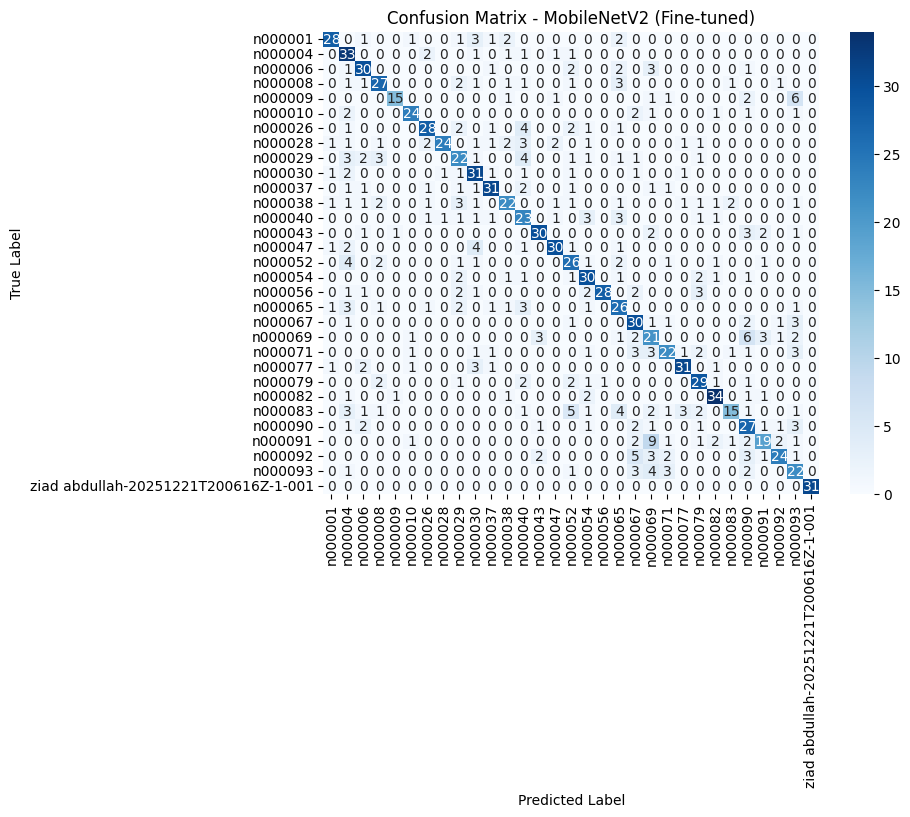

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# -------- Collect predictions from test set --------
y_true = []
y_pred = []

for images, labels in test_ds:
    outputs = model(images, training=False)
    preds = tf.argmax(outputs, axis=1).numpy()

    y_true.extend(labels.numpy())
    y_pred.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# -------- Accuracy (Final) --------
final_acc = accuracy_score(y_true, y_pred)
print(f"\nFinal Test Accuracy (Evaluation): {final_acc:.4f}")

# -------- Precision / Recall / F1-score --------
print("\n📊 Classification Report (Precision, Recall, F1):")
print(classification_report(
    y_true,
    y_pred,
    target_names=class_names
))

# -------- Confusion Matrix --------
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - MobileNetV2 (Fine-tuned)")
plt.show()

## Final Summary

The model was trained using a manual training loop to explicitly control gradient computation and weight updates.
Transfer learning was applied using MobileNetV2 as a feature extractor.
The best model was selected using validation accuracy.
Fine-tuning was then performed on the upper layers to improve task-specific performance while preserving general features.